# Neural Collabrative Filtering

### Pre-requisites

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

### Import necessary libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### Load the data

In [3]:
df = pd.read_csv('D:/Movie_Recommendation/merged_moviecine_tmdb.csv')
df.sample(5)

,user_id,movie_id,rating,timestamp,title,release_date,genre_names,original_language_full
358248,7090,153,3.0,1484024230,Lost in Translation,2003-09-18,"['Drama', 'Romance', 'Comedy']",English
6705877,127955,140711,2.5,1520636840,Love from the Passage,1985-07-01,['Crime'],Czech
2080236,39535,3638,3.0,1103060095,No Reservations,2007-06-15,"['Comedy', 'Romance', 'Drama']",English
9915682,189465,364,5.0,943495407,Batman Returns,1992-06-19,"['Action', 'Fantasy']",English
876148,16883,1921,4.0,1165257394,Sweet November,2001-02-16,"['Drama', 'Romance']",English


### Encoding the data

In [4]:
user_enc = LabelEncoder()
movie_enc = LabelEncoder()

df['user'] = user_enc.fit_transform(df['user_id'])
df['movie'] = movie_enc.fit_transform(df['movie_id'])

In [5]:
num_users = df['user'].nunique()
num_movies = df['movie'].nunique()

### Train test Split


In [6]:
train_df, test_df = train_test_split(df[['user', 'movie', 'rating']], test_size=0.2, random_state=42)

### Pytorch Dataset

In [7]:
class RatingDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df['user'].values, dtype=torch.long)
        self.items = torch.tensor(df['movie'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['rating'].values, dtype=torch.float)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

train_dataset = RatingDataset(train_df)
test_dataset = RatingDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

### Model Building

In [8]:
class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=32):
        super(NCF, self).__init__()
        
        # GMF part
        self.user_embed_gmf = nn.Embedding(num_users, embedding_dim)
        self.item_embed_gmf = nn.Embedding(num_items, embedding_dim)

        # MLP part
        self.user_embed_mlp = nn.Embedding(num_users, embedding_dim)
        self.item_embed_mlp = nn.Embedding(num_items, embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        # Final layer
        self.output_layer = nn.Linear(embedding_dim + 1, 1)  

    def forward(self, user, item):
        # GMF part
        gmf_user = self.user_embed_gmf(user)
        gmf_item = self.item_embed_gmf(item)
        gmf_out = gmf_user * gmf_item  # Element-wise multiplication for GMF

        # MLP part
        mlp_user = self.user_embed_mlp(user)
        mlp_item = self.item_embed_mlp(item)
        mlp_input = torch.cat([mlp_user, mlp_item], dim=-1)
        mlp_out = self.mlp(mlp_input)  # MLP outputs a single value for each user-item pair

        # Concatenate GMF + MLP outputs
        final_input = torch.cat([gmf_out, mlp_out], dim=-1)  # Concatenate the outputs
        prediction = self.output_layer(final_input)  # Final layer to produce the predicted rating
        return prediction.squeeze()  # Return the final prediction

### Model Training

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_losses = []
model = NCF(num_users, num_movies).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for users, movies, ratings in train_loader:
        users, items, ratings = users.to(device), movies.to(device), ratings.to(device)
        preds = model(users, movies)
        loss = loss_fn(preds, ratings)
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        total_loss += loss.item()
    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}")

Epoch 1/20, Loss: 1.0308
Epoch 2/20, Loss: 0.7814
Epoch 3/20, Loss: 0.7416
Epoch 4/20, Loss: 0.7250
Epoch 5/20, Loss: 0.7110
Epoch 6/20, Loss: 0.6945
Epoch 7/20, Loss: 0.6742
Epoch 8/20, Loss: 0.6504
Epoch 9/20, Loss: 0.6241
Epoch 10/20, Loss: 0.5968
Epoch 11/20, Loss: 0.5697
Epoch 12/20, Loss: 0.5438
Epoch 13/20, Loss: 0.5195
Epoch 14/20, Loss: 0.4969
Epoch 15/20, Loss: 0.4763
Epoch 16/20, Loss: 0.4574
Epoch 17/20, Loss: 0.4404
Epoch 18/20, Loss: 0.4247
Epoch 19/20, Loss: 0.4106
Epoch 20/20, Loss: 0.3979


### Model Evaluation

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)
loss_fn1 = nn.MSELoss()

model.eval()
all_preds = []
all_targets = []
val_losses = []
val_loss = 0  # Initialize val_loss

with torch.no_grad():
    for users, movies, ratings in test_loader:
        users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)

        preds = model(users, movies)
        preds = preds.view(-1)
        ratings = ratings.view(-1)

        loss = loss_fn1(preds, ratings)
        val_loss += loss.item()

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(ratings.cpu().numpy())

val_loss /= len(test_loader)
val_losses.append(val_loss)


rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
mae = mean_absolute_error(all_targets, all_preds)

print(f"\nEvaluation Results:")
print(f"Validation Loss: {val_loss:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")


Evaluation Results:
Validation Loss: 0.8649
RMSE: 0.9300
MAE : 0.7220


In [11]:
import numpy as np
import torch

def evaluate_topk_metrics(model, test_df, all_items, k=10, num_users=1000, device='cpu'):
    """
    Evaluate HitRate@K, Precision@K, and NDCG@K.

    model: trained PyTorch NCF model
    test_df: DataFrame with columns ['user', 'movie']
    all_items: set of all item IDs
    k: top-k items to consider
    num_users: number of users to evaluate
    device: 'cuda' or 'cpu'
    """
    model.eval()
    hits, ndcgs, precisions = [], [], []

    users = test_df['user'].unique()
    sampled_users = np.random.choice(users, min(num_users, len(users)), replace=False)

    for user in sampled_users:
        true_item = test_df[test_df['user'] == user]['movie'].values[0]

        # Sample 99 negative items
        negatives = list(all_items - set(test_df[test_df['user'] == user]['movie']))
        if len(negatives) < 99:
            continue  
        sampled_negatives = np.random.choice(negatives, size=99, replace=False).tolist()

        
        test_items = [true_item] + sampled_negatives
        user_tensor = torch.tensor([user] * len(test_items)).to(device)
        item_tensor = torch.tensor(test_items).to(device)

        with torch.no_grad():
            scores = model(user_tensor, item_tensor).squeeze().cpu().numpy()

        ranked_indices = np.argsort(-scores)
        ranked_items = np.array(test_items)[ranked_indices]

        top_k = ranked_items[:k]
        hit = int(true_item in top_k)
        hits.append(hit)

        if hit:
            rank_position = np.where(top_k == true_item)[0][0] + 1
            ndcgs.append(1 / np.log2(rank_position + 1))
        else:
            ndcgs.append(0)

        precisions.append(hit / k)

    return {
        "HitRate@K": np.mean(hits),
        "Precision@K": np.mean(precisions),
        "NDCG@K": np.mean(ndcgs)
    }

In [12]:
all_items = set(df['movie'].unique())


test_df = df.groupby('user').first().reset_index()[['user', 'movie']]

metrics = evaluate_topk_metrics(model, test_df, all_items, k=10, device=device)
print(f"Evaluation Results:")
print(f"HitRate@10  : {metrics['HitRate@K']:.4f}")
print(f"Precision@10: {metrics['Precision@K']:.4f}")
print(f"NDCG@10     : {metrics['NDCG@K']:.4f}")

Evaluation Results:
HitRate@10  : 0.1970
Precision@10: 0.0197
NDCG@10     : 0.0872


### Output Visualization

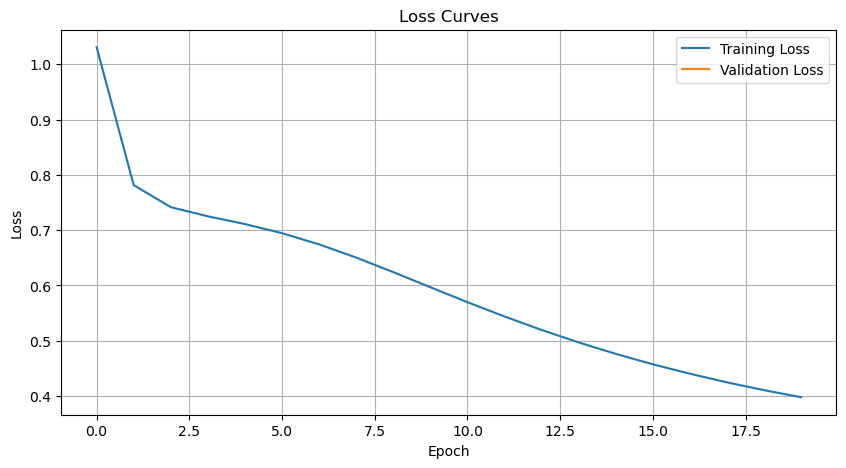

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Dumping the model and encoders

In [14]:
import pickle
torch.save(model.state_dict(), "ncf_model.pth")

with open("movie_encoder.pkl", "wb") as f:
    pickle.dump(movie_enc, f)
with open("user_encoder.pkl", "wb") as f:
    pickle.dump(user_enc, f)